In [10]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

In [11]:
# Pre Processing
df = pd.read_csv('./movies.csv')
df['genres'] = [i.split('|') for i in df['genres']]

all_genres = set(genre for row in df['genres'] for genre in row) #Finding unique genres
print(all_genres)

#Encoding Genres
for genre in all_genres:
    df[genre] = df['genres'].apply(lambda x: 1 if genre in x else 0)
df = df.drop('genres', axis=1)

features = df.drop(['movieId', 'title'], axis=1)
    

{'Animation', 'Sci-Fi', 'War', 'Western', 'Action', 'Film-Noir', 'Documentary', 'Musical', 'Children', 'Mystery', 'IMAX', 'Horror', 'Comedy', '(no genres listed)', 'Drama', 'Romance', 'Thriller', 'Crime', 'Adventure', 'Fantasy'}


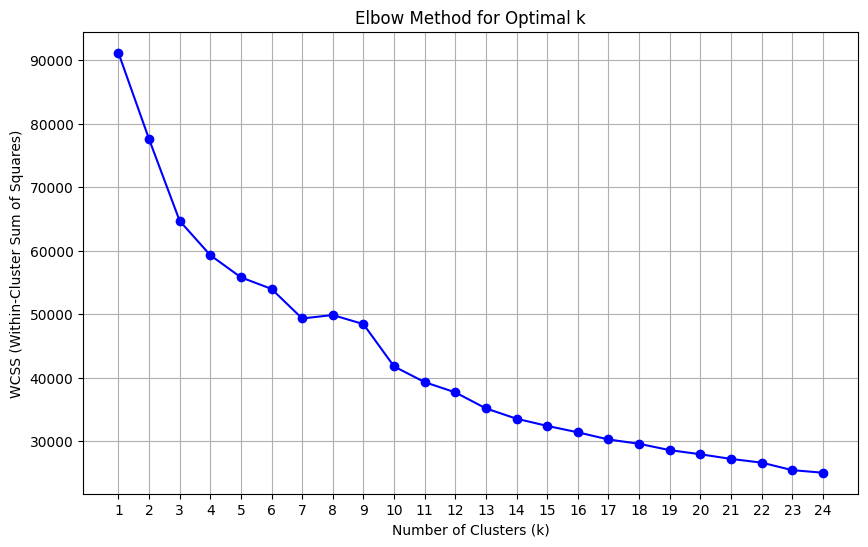

In [12]:
# K-MEANS
wcss = []
for k in range(1, 25):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS value

# Plotting the elbow graph

plt.figure(figsize=(10, 6))
plt.plot(range(1, 25), wcss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 25))
plt.grid(True)
plt.show()


In [13]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
df['cluster'] = kmeans.fit_predict(features)
print(df['cluster'])

0        0
1        1
2        0
3        0
4        0
        ..
62418    3
62419    1
62420    3
62421    1
62422    3
Name: cluster, Length: 62423, dtype: int32


In [14]:
#Helper Functions


#Movies Input Function
def movieInput():
    input_movies=[]

    while True:
        input_movie =input("Type 'N/n' if you want to stop adding movies: ")
        if input_movie == 'N':
            return input_movies
        elif input_movie not in df['title'].values:
            print(f"Movie '{input_movie}' not found in the dataset.")
        else:
            input_movies.append(input_movie)
            print(f"{input_movie} added")


def recommend_movies_kmeans(movies, df, features, top_n=5):
    recommendations = []  # List to collect all recommendations

    for movie_title in movies:
        # Find the index of the input movie
        movie_i = df[df['title'] == movie_title].index[0]
        
        # Get the feature vector for the input movie
        movie_features = features.loc[movie_i]
        
        # Get the cluster of the input movie
        movie_cluster = df.loc[movie_i, 'cluster']
        
        # Get all movies in the same cluster
        similar_movies = df[df['cluster'] == movie_cluster].copy()
        
        # Calculate distances from the input movie to others in the same cluster
        for i in similar_movies.index:
            if df.loc[i, 'title'] != movie_title:  # Exclude the input movie
                distance = np.linalg.norm(features.loc[i] - movie_features)
                recommendations.append((df.loc[i, 'title'], distance))
    
    if len(movies) == 1:
        # For a single movie, sort recommendations directly by distance
        rec_df = pd.DataFrame(recommendations, columns=['title', 'distance'])
        rec_df = rec_df.sort_values('distance').head(top_n)
        return rec_df
    
    # For multiple movies, aggregate distances by title and compute total distance
    rec_df = pd.DataFrame(recommendations, columns=['title', 'distance'])
    rec_df = rec_df.groupby('title', as_index=False).agg(total_distance=('distance', 'sum'))
    rec_df = rec_df.sort_values('total_distance').head(top_n)
    
    return rec_df


In [15]:
#K means Testing

movies=movieInput()
rec=recommend_movies_kmeans(movies, df, features,5)
print(rec)

Type 'N/n' if you want to stop adding movies:  Interstellar (2014)


Interstellar (2014) added


Type 'N/n' if you want to stop adding movies:  Iron Man (2008)


Iron Man (2008) added


Type 'N/n' if you want to stop adding movies:  Avatar (2009)


Avatar (2009) added


Type 'N/n' if you want to stop adding movies:  N


                                                   title  total_distance
14311  Star Wars: Episode II - Attack of the Clones (...        2.414214
5094                                 Ender's Game (2013)        2.414214
16233             The Hunger Games: Catching Fire (2013)        2.414214
1509                                Avengers, The (2012)        2.414214
2903          Captain America: The Winter Soldier (2014)        2.414214


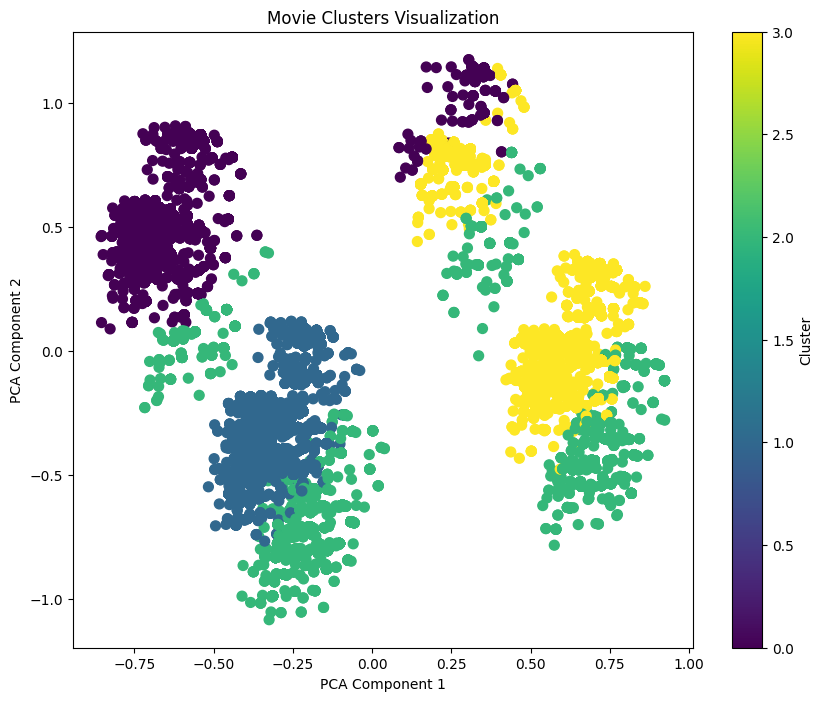

In [16]:
#Visualisation for reference by GPT
# Reduce dimensions to 2 for visualization (using PCA)
pca = PCA(n_components=2)
pca_features = pca.fit_transform(df.drop(['movieId', 'title', 'cluster'], axis=1))  # Drop non-numeric columns
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=df['cluster'], cmap='viridis', s=50)
plt.colorbar(scatter, label='Cluster')
plt.title('Movie Clusters Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [21]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Function to apply DBSCAN on scaled features
def apply_dbscan(scaled_features, eps=0.15, min_samples=4):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    df['cluster'] = dbscan.fit_predict(scaled_features)
    return df
num_clusters = len(set(df['cluster'])) - (1 if -1 in df['cluster'] else 0)

# Print the result
print(f"Number of clusters formed by DBSCAN: {num_clusters}")
df = apply_dbscan(scaled_features)

def recommend_movies_dbscan(movie_titles, df, scaled_features, top_n=5, eps=0.5, min_samples=5):
    recommendations = []
    
    for movie_title in movie_titles:
        
        # Find the index of the input movie
        movie_idx = df[df['title'] == movie_title].index[0]
        
        # Check if the movie is in a valid cluster or is noise (-1)
        movie_cluster = df.loc[movie_idx, 'cluster']
        if movie_cluster == -1:
            print(f"Movie '{movie_title}' is considered noise by DBSCAN. Skipping.")
            continue
        
        # Get the features of the input movie from scaled_features
        movie_features = scaled_features[movie_idx]
        # Get movies from the same cluster
        similar_movies = df[df['cluster'] == movie_cluster].copy()
        # Calculate distances from the input movie to all other movies in the cluster
        distances = []
        for i in similar_movies.index:
            if df.loc[i, 'title'] != movie_title:  # Exclude the input movie
                distance = np.linalg.norm(scaled_features[i] - movie_features)
                distances.append((df.loc[i, 'title'], distance))
        
        # Sort by distance and get top_n recommendations
        recommendations.extend(sorted(distances, key=lambda x: x[1])[:top_n])
    
    # Combine all recommendations, remove duplicates, sort by distance, and limit to top_n
    unique_recommendations = list(set(recommendations))
    sorted_recommendations = sorted(unique_recommendations, key=lambda x: x[1])
    final_recommendations = sorted_recommendations[:top_n]
    
    # Return recommendations as DataFrame
    return pd.DataFrame(final_recommendations, columns=['title', 'distance'])


Number of clusters formed by DBSCAN: 592


In [18]:
noise_movies = df[df['cluster'] == -1]
print(f"Number of noise movies: {len(noise_movies)}")
print(df['cluster'].value_counts())

Number of noise movies: 1526
cluster
11     9056
4      5674
537    5062
38     4731
37     2386
       ... 
198       4
284       4
375       4
208       4
590       4
Name: count, Length: 592, dtype: int64


In [19]:
# Example usage
movie_list = ['Shutter Island (2010)', 'Iron Man (2008)', 'Avatar (2009)']
recommendations = recommend_movies_dbscan(movie_list, df, scaled_features, top_n=5)
print(recommendations)

                                               title  distance
0  Star Wars: Episode V - The Empire Strikes Back...       0.0
1  Star Wars: Episode II - Attack of the Clones (...       0.0
2                        The Devil's Advocate (1997)       0.0
3          Star Wars: Episode IV - A New Hope (1977)       0.0
4                                  Waterworld (1995)       0.0


In [7]:
# Agglomerative Clustering
optimal_k = 4  # Number of clusters
agglomerative = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
df['cluster'] = agglomerative.fit_predict(features)

# Testing
movies = movieInput()
rec = recommend_movies_kmeans(movies, df, features, 5) #same function of kmeans can be used here as well
print(rec)

Type 'N/n' if you want to stop adding movies:  Shutter Island (2010)


Shutter Island (2010) added


Type 'N/n' if you want to stop adding movies:  The Devil's Advocate (1997)


The Devil's Advocate (1997) added


Type 'N/n' if you want to stop adding movies:  Insomnia (1997)


Insomnia (1997) added


Type 'N/n' if you want to stop adding movies:  N


                                                   title  total_distance
17737                                    Silencio (2018)             0.0
9087   Headless Woman, The (Mujer sin cabeza, La) (2008)             0.0
20638                         The Great Hypnotist (2014)             0.0
15594                                   Prisoners (2013)             0.0
1531                                          Arc (2006)             0.0
